# Pima Indians Diabetes Database
#### Predict the onset of diabetes based on diagnostic measures

This data is collected by UCI Machine Learning Repository. The data is available at [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes). The data is also available at [Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

Pima, North American Indians who traditionally lived along the Gila and Salt rivers in Arizona, U.S., in what was the core area of the prehistoric Hohokam culture. The Pima, who speak a Uto-Aztecan language and call themselves the “River People,” are usually considered to be the descendants of the Hohokam.

<center> <img src="R.jpg" width = "500"/> </center>

The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

__________

This data's goal is to predict whether a patient has diabetes or not. The data has 768 rows and 9 columns. The data has no missing values. The data has 500 non-diabetic patients and 268 diabetic patients. The data has 8 features and 1 target variable. The features are:

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure $ (mm Hg) $
* SkinThickness: Triceps skin fold thickness $ (mm) $
* Insulin: 2-Hour serum insulin $ (\mu U/ml) $ 
* BMI: Body mass index $( \frac{kg}{m^2} )$
* DiabetesPedigreeFunction: Measure of genetic influence that shows the hereditary risk of diabetes mellitus based on the diabetes history of relatives.
* Age: Age (years)
* Outcome: Class variable (0 or 1)

____________________

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import miceforest as mf
import ppscore as pps
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('diabetes.csv')
display(df.head())
display(df.info())

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

Very good, looks clean with no missing values, as expected from a dataset from the UCI Machine Learning Repository. Let's take a look at the data.

In [3]:
display(df.describe()) #describe first then cast, otherwise we won't see the mean and std of the categorical variables
df.Outcome = df.Outcome.astype('bool')

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

Zero pregnancies is acceptable, but 17 pregnancies is a bit high. we'll take a look at the distribution of pregnancies. Also 0 Glucose is not possible, and zero blood pressure, skin thickness, insulin, and BMI are also not possible. We'll take a look at the distribution of these variables as well.


This chart shows that BMI of 67.1 is unlikely. We'll take a look at the distribution of BMI.
<center> <img src= "BMI_chart.png" width = "500"/> </center>

[Source](https://www.cdc.gov/)


## EDA and preprocessing

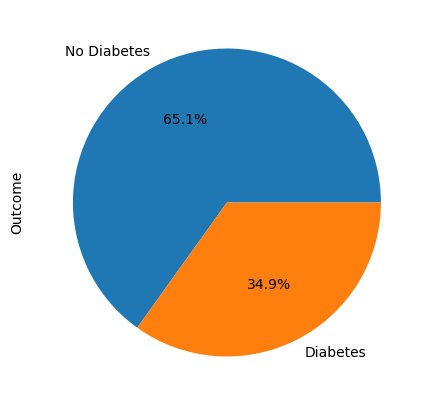

In [4]:
df.Outcome.value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['No Diabetes', 'Diabetes'], figsize=(5,5));

After splitting, I'll undersample the data to make conclusions easier to get.

In [5]:
#split the data into train and test
X_train = df.drop('Outcome', axis=1)
y_train = df.Outcome

In [6]:
#undersample the data
rus = SMOTE(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

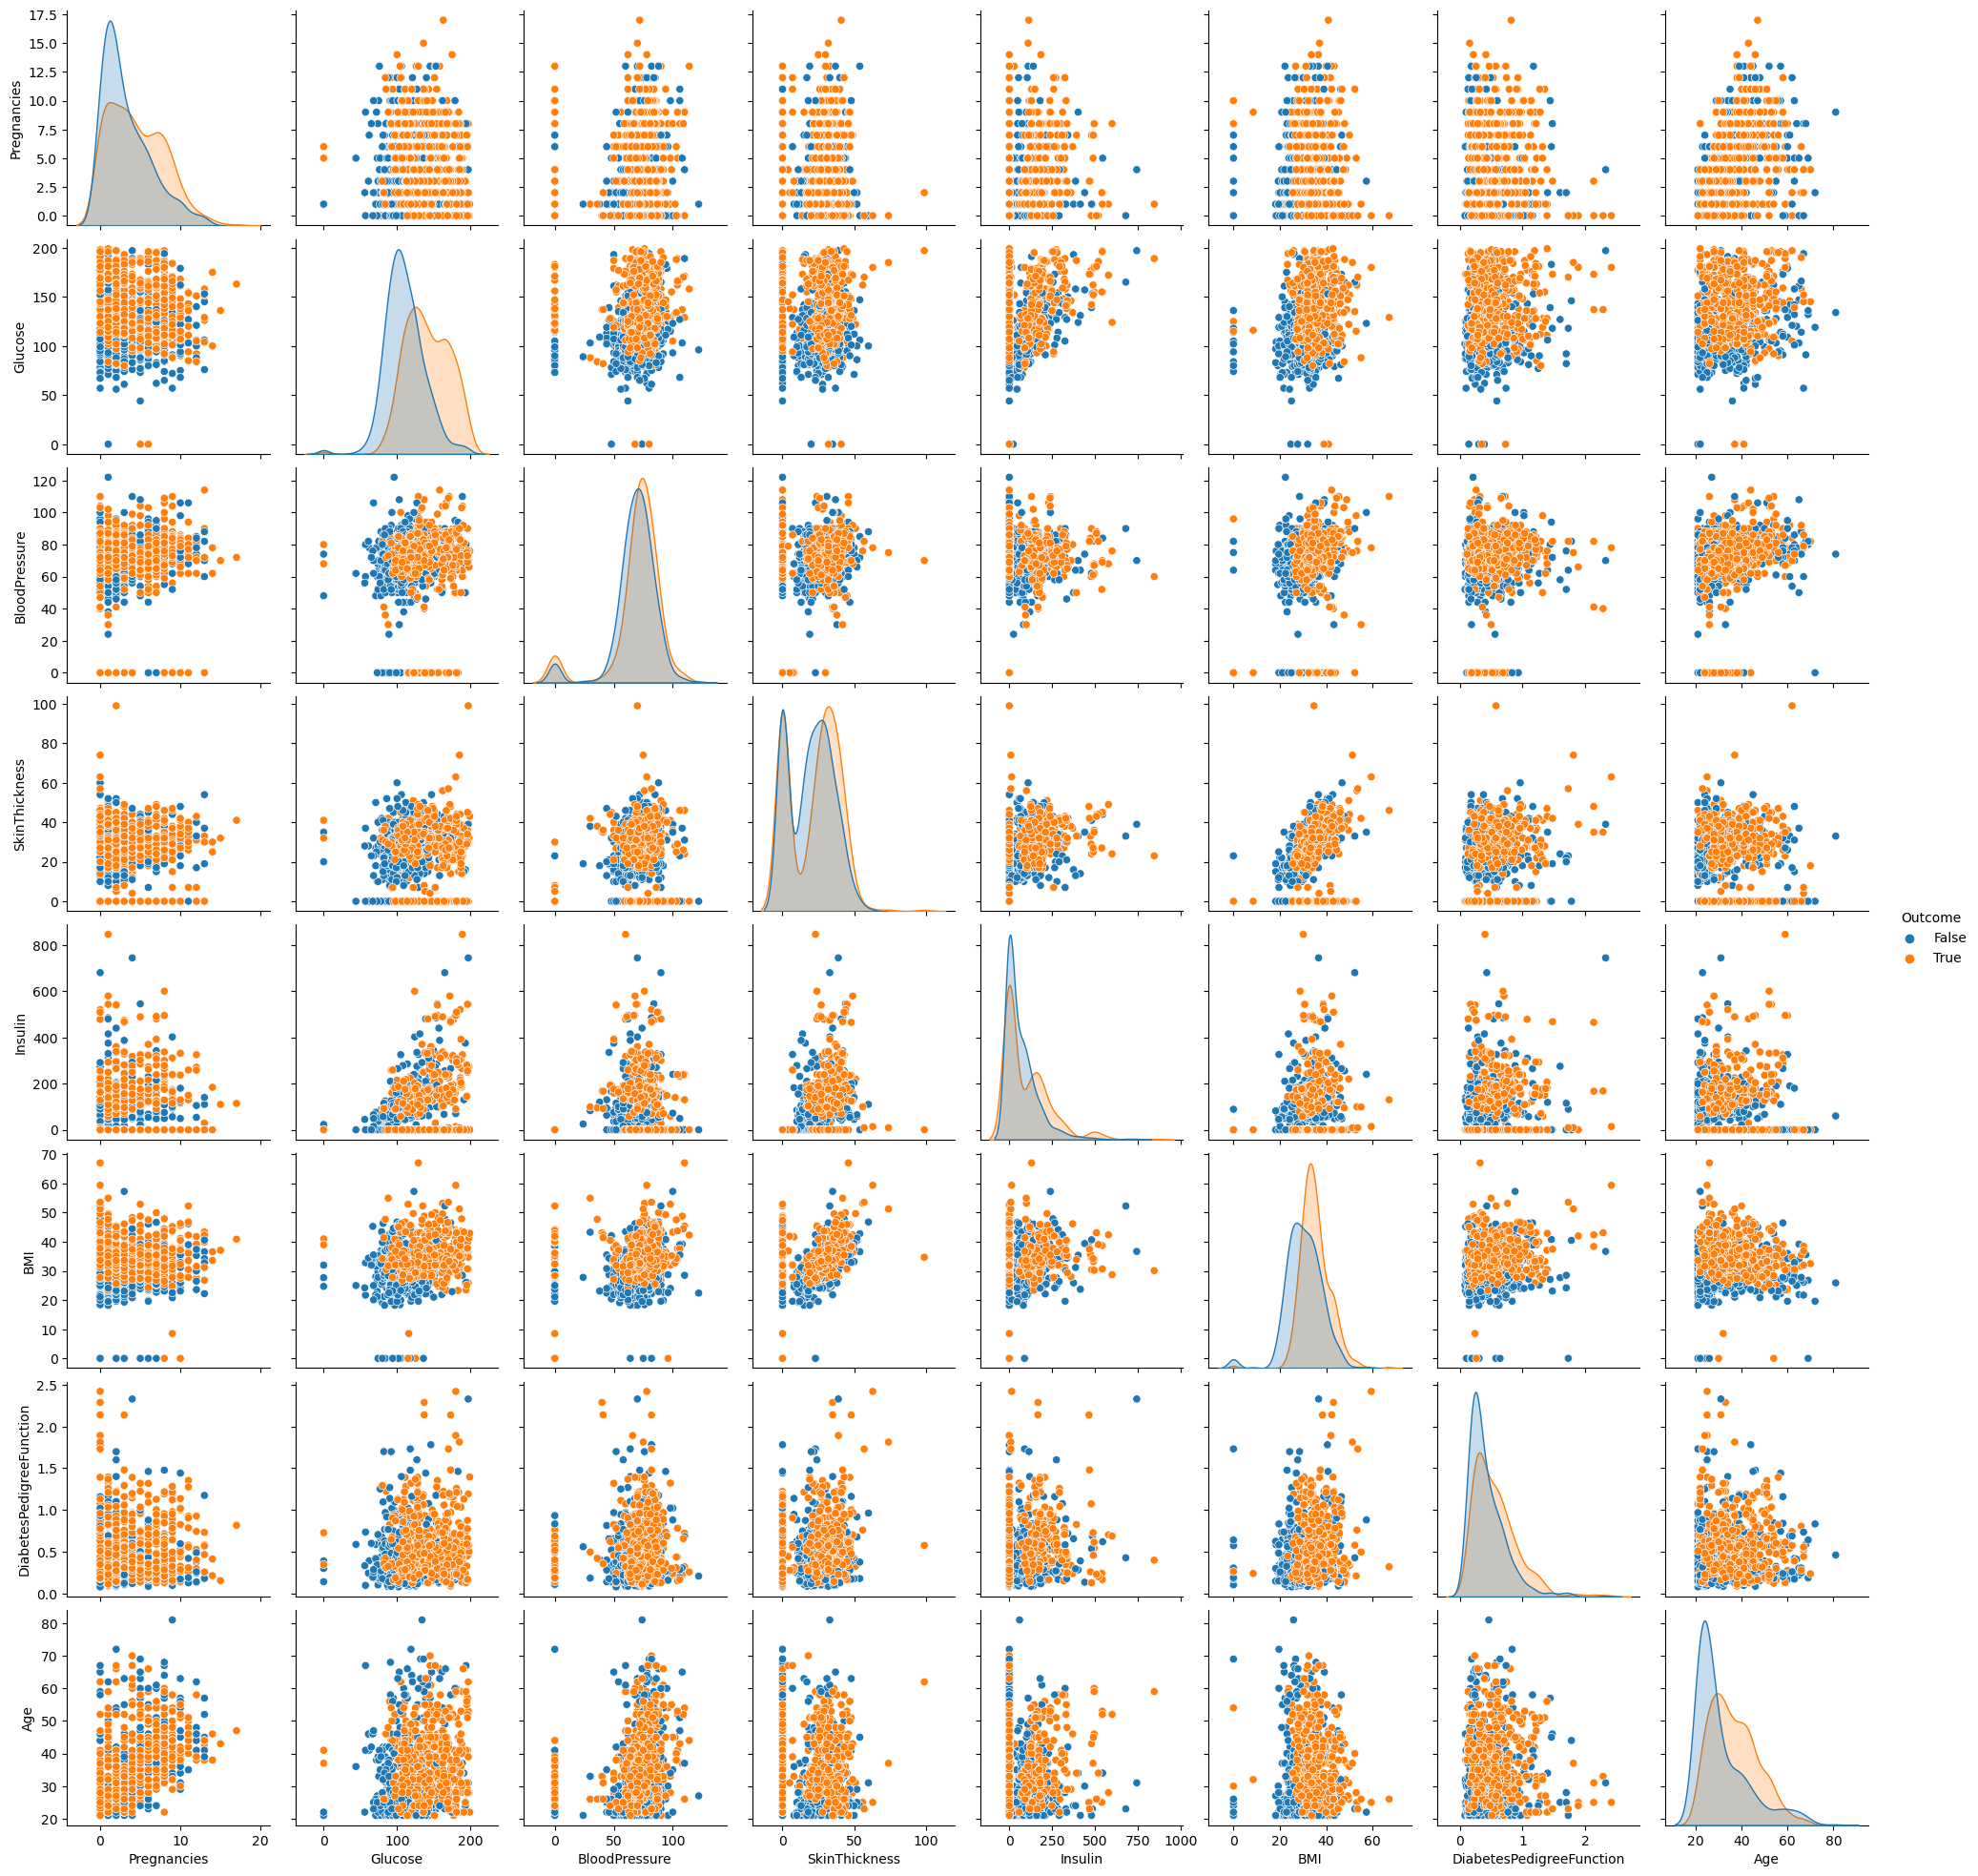

In [7]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), hue='Outcome');

$\rightarrow$ It's now obvious that with age, the chance of diabetes increases, the crossover point is around 30 years old.

$\rightarrow$ BMI is also a good indicator of diabetes. The crossover point is around also around $30 \frac{kg}{m^2}$.

   $H_0:$ There is _no_ relationship between the BMI and diabetes.

   $H_1:$ The more BMI the more chance of diabetes.


$\rightarrow$ More Glucose means more chance of diabetes.

$\rightarrow$ Blood pressure is not a good indicator of diabetes.

   $H_0:$ There is _no_ relationship between the Blood Pressure and diabetes.

   $H_1:$ The more Blood Pressure the more chance of diabetes.

We'll address each of these questions in turn after we've done some data cleaning.

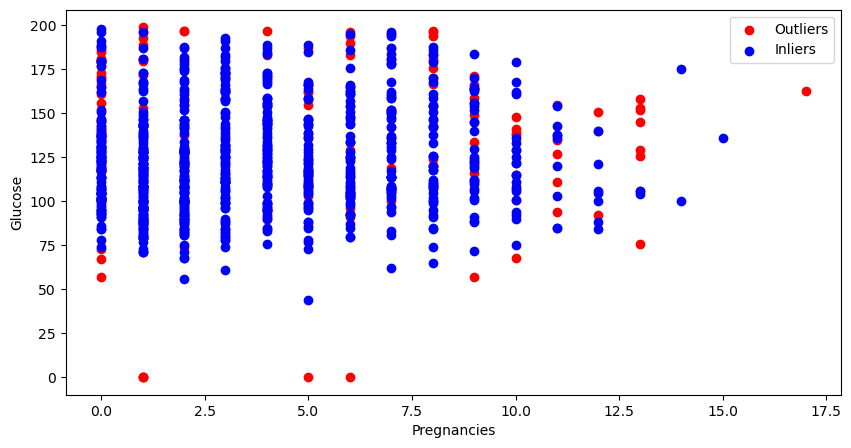

In [8]:
#check outliers
clf = IsolationForest(random_state=42)
clf.fit(X_train)
y_pred = clf.predict(X_train)

#plot the outliers
plt.figure(figsize=(10,5))
plt.scatter(X_train[y_pred == -1].Pregnancies, X_train[y_pred == -1].Glucose, color='red', label='Outliers')
plt.scatter(X_train[y_pred == 1].Pregnancies, X_train[y_pred == 1].Glucose, color='blue', label='Inliers')
plt.xlabel('Pregnancies')
plt.ylabel('Glucose')
plt.legend();

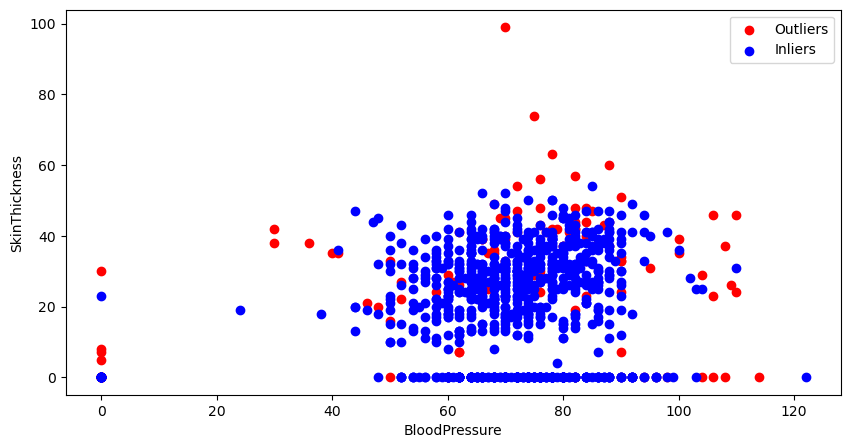

In [9]:
plt.figure(figsize=(10,5))
plt.scatter(X_train[y_pred == -1].BloodPressure, X_train[y_pred == -1].SkinThickness, color='red', label='Outliers')
plt.scatter(X_train[y_pred == 1].BloodPressure, X_train[y_pred == 1].SkinThickness, color='blue', label='Inliers')
plt.xlabel('BloodPressure')
plt.ylabel('SkinThickness')
plt.legend();

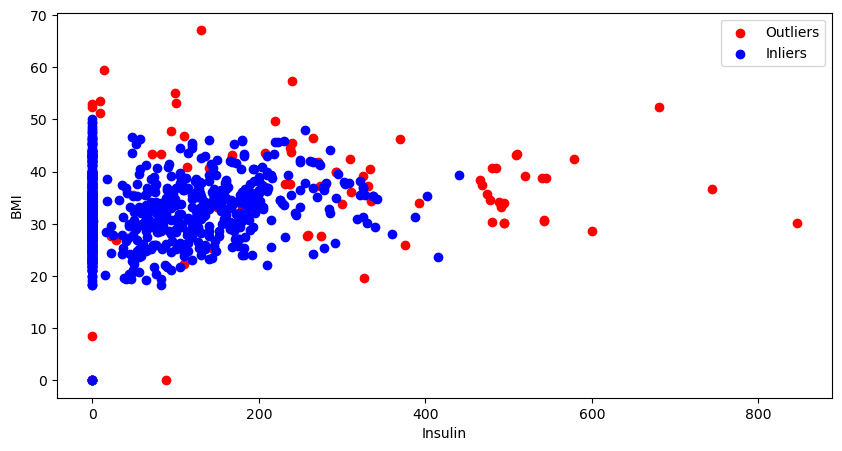

In [10]:
plt.figure(figsize=(10,5))
plt.scatter(X_train[y_pred == -1].Insulin, X_train[y_pred == -1].BMI, color='red', label='Outliers')
plt.scatter(X_train[y_pred == 1].Insulin, X_train[y_pred == 1].BMI, color='blue', label='Inliers')
plt.xlabel('Insulin')
plt.ylabel('BMI')
plt.legend();

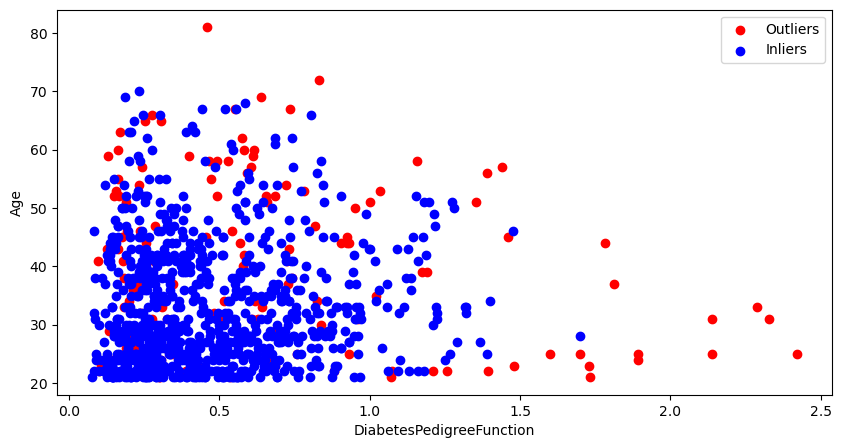

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(X_train[y_pred == -1].DiabetesPedigreeFunction, X_train[y_pred == -1].Age, color='red', label='Outliers')
plt.scatter(X_train[y_pred == 1].DiabetesPedigreeFunction, X_train[y_pred == 1].Age, color='blue', label='Inliers')
plt.xlabel('DiabetesPedigreeFunction')
plt.ylabel('Age')
plt.legend();

In [12]:
X_train = X_train[y_pred == 1]
y_train = y_train[y_pred == 1]

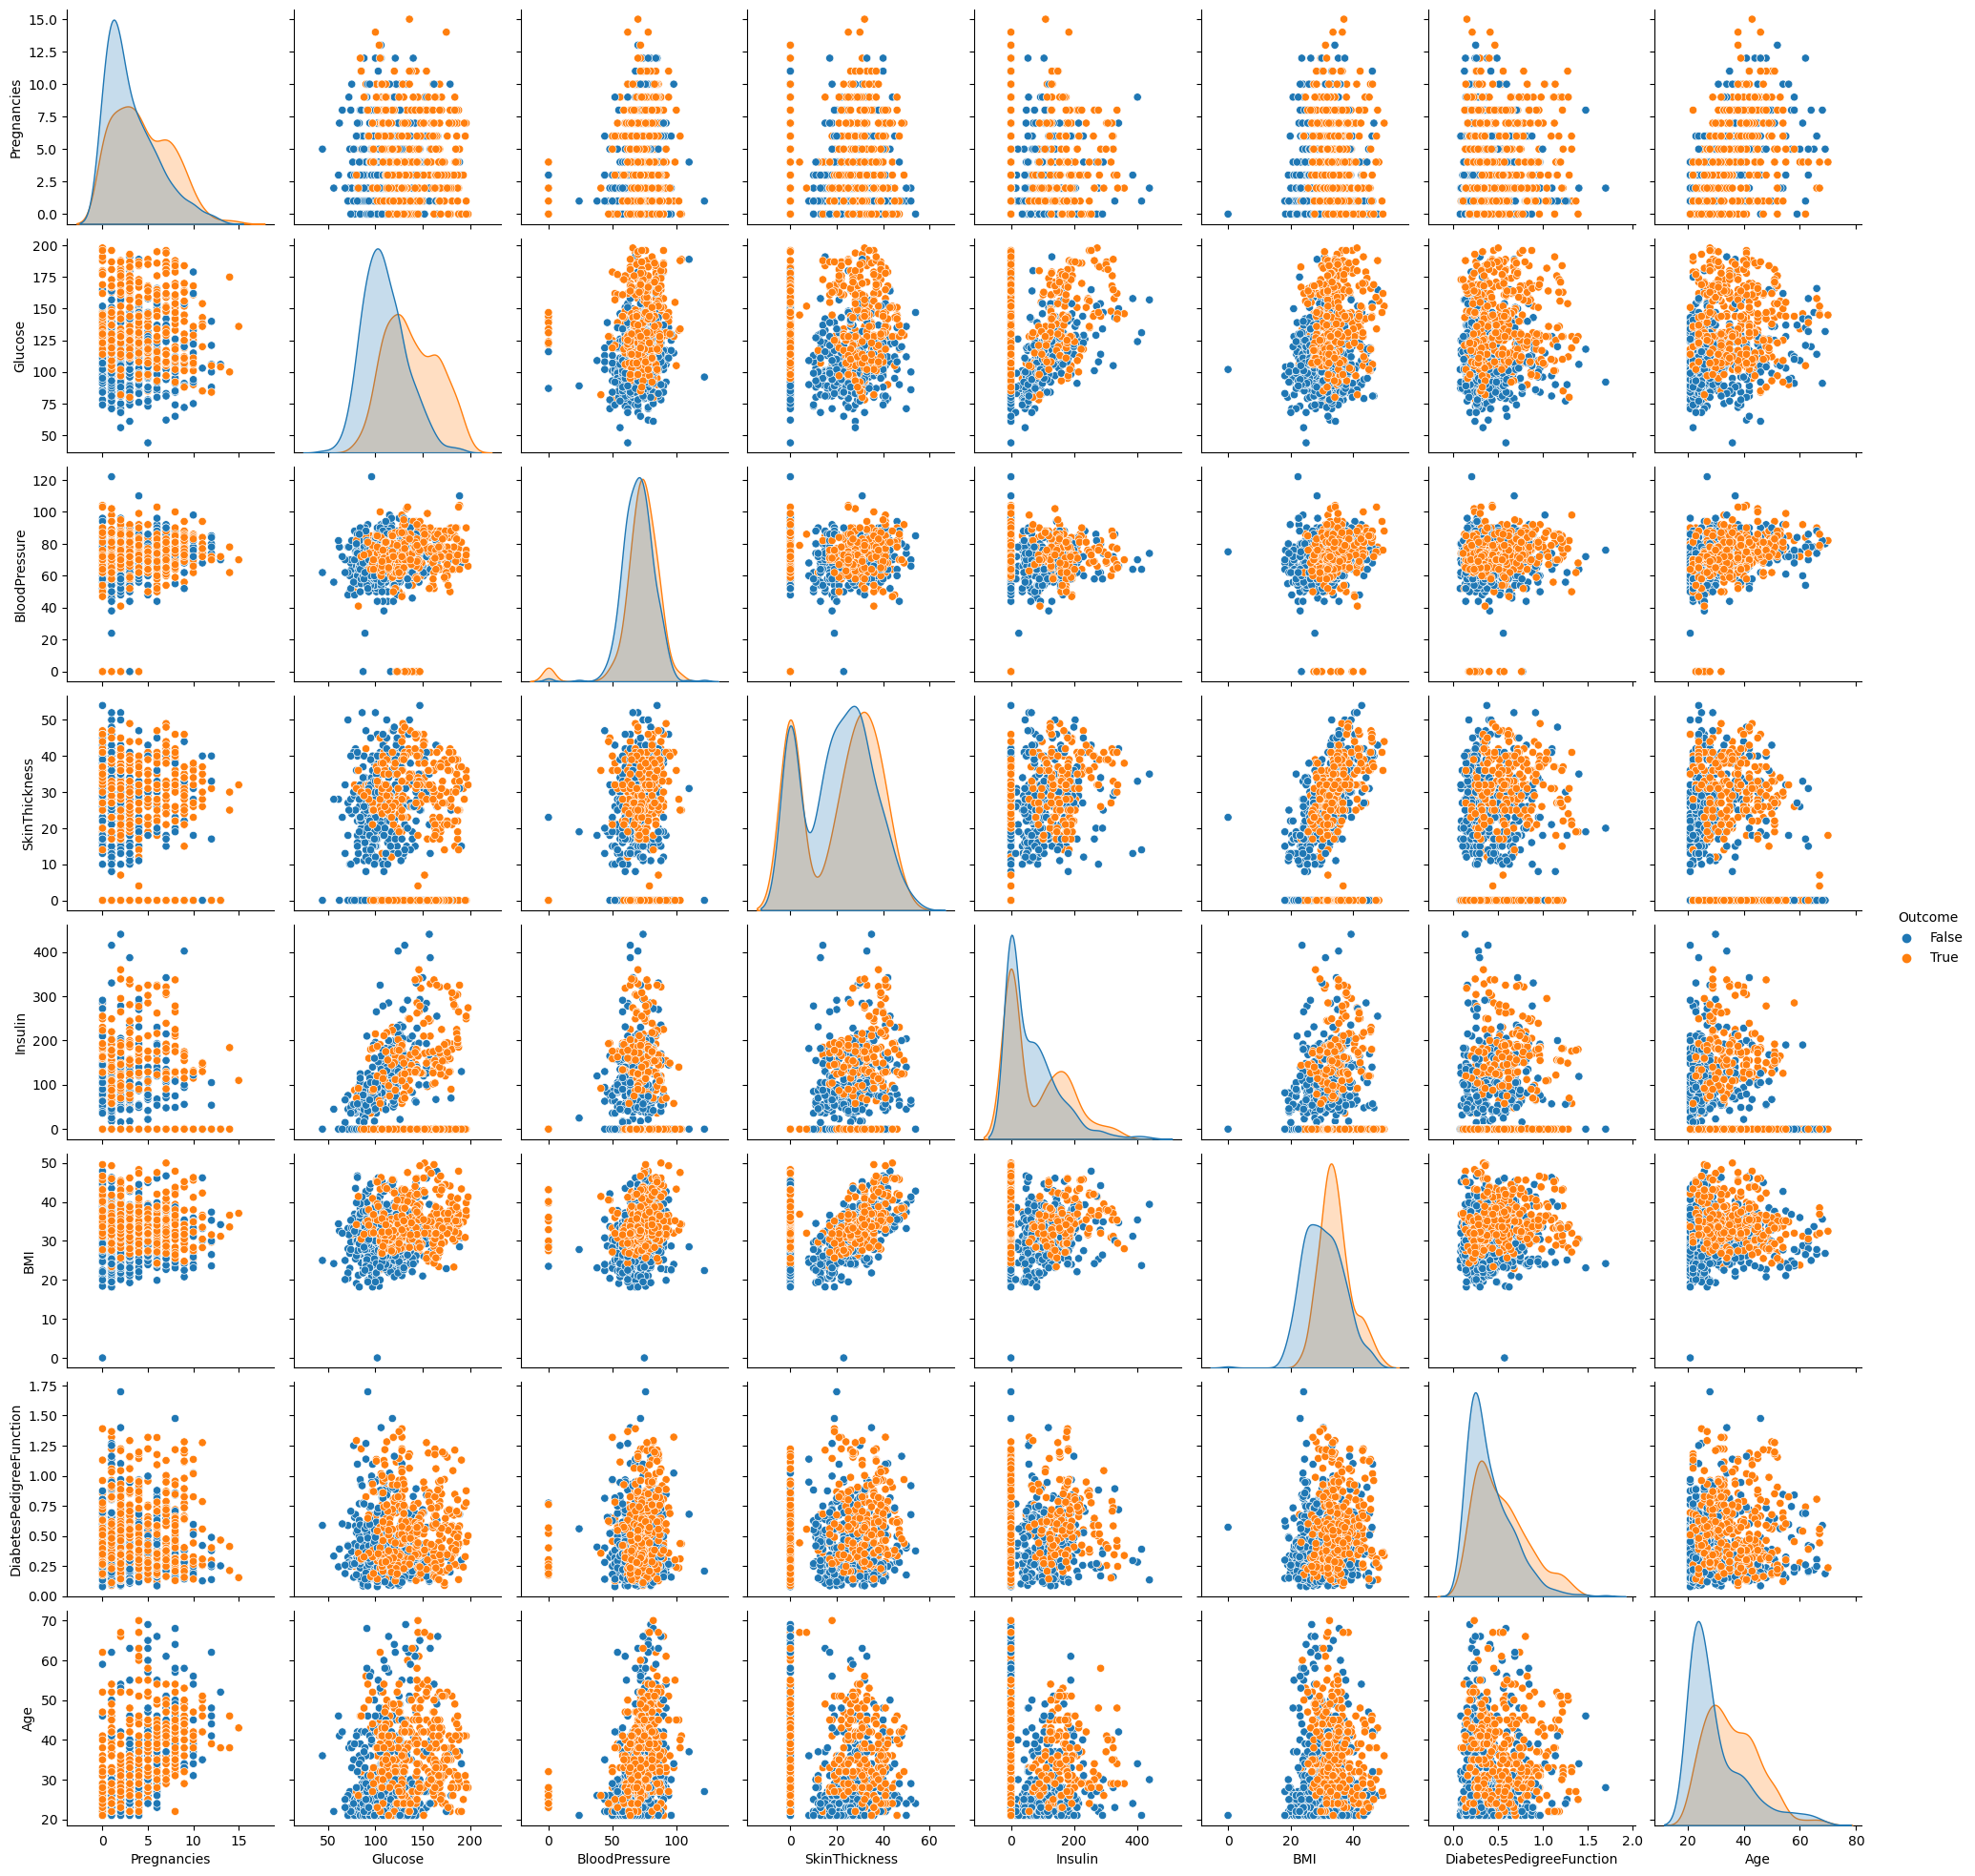

In [13]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), hue='Outcome');

2-hour serum insulin, skin thickness, and blood pressure can't be zero, we'll treat them as missing values and impute them with forest imputation.

In [14]:
#replace 0 with nan
X_train = X_train.replace(0, np.nan)
X_train.Pregnancies = X_train.Pregnancies.fillna(0)

Sure, half of the data is missing, but we can't just drop half of the data. We'll impute the missing values with forest imputation.

In [15]:
mice = mf.ImputationKernel(
    X_train,
    random_state=42
)

mice.mice(5)

In [16]:
X_train = mice.complete_data()

In [17]:
X_train.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   852.000000  852.000000     852.000000     852.000000  852.000000   
mean      3.767606  123.258216      72.207746      28.409624  140.010563   
std       3.061068   28.974546      10.922988       8.934810   71.913603   
min       0.000000   44.000000      24.000000       4.000000    1.000000   
25%       1.000000  102.000000      64.000000      22.000000   87.000000   
50%       3.000000  119.000000      72.000000      28.000000  127.500000   
75%       6.000000  143.000000      80.000000      35.000000  180.000000   
max      15.000000  198.000000     122.000000      54.000000  440.000000   

              BMI  DiabetesPedigreeFunction         Age  
count  852.000000                852.000000  852.000000  
mean    32.421356                  0.470866   33.044601  
std      6.030890                  0.279117   10.483063  
min     18.200000                  0.078000   21.000000  
25%     28.200000                  0.258000   25.000000  
50%     32.400000                  0.398866   30.000000  
75%     35.913238                  0.630714   40.000000  
max     50.000000                  1.698000   70.000000

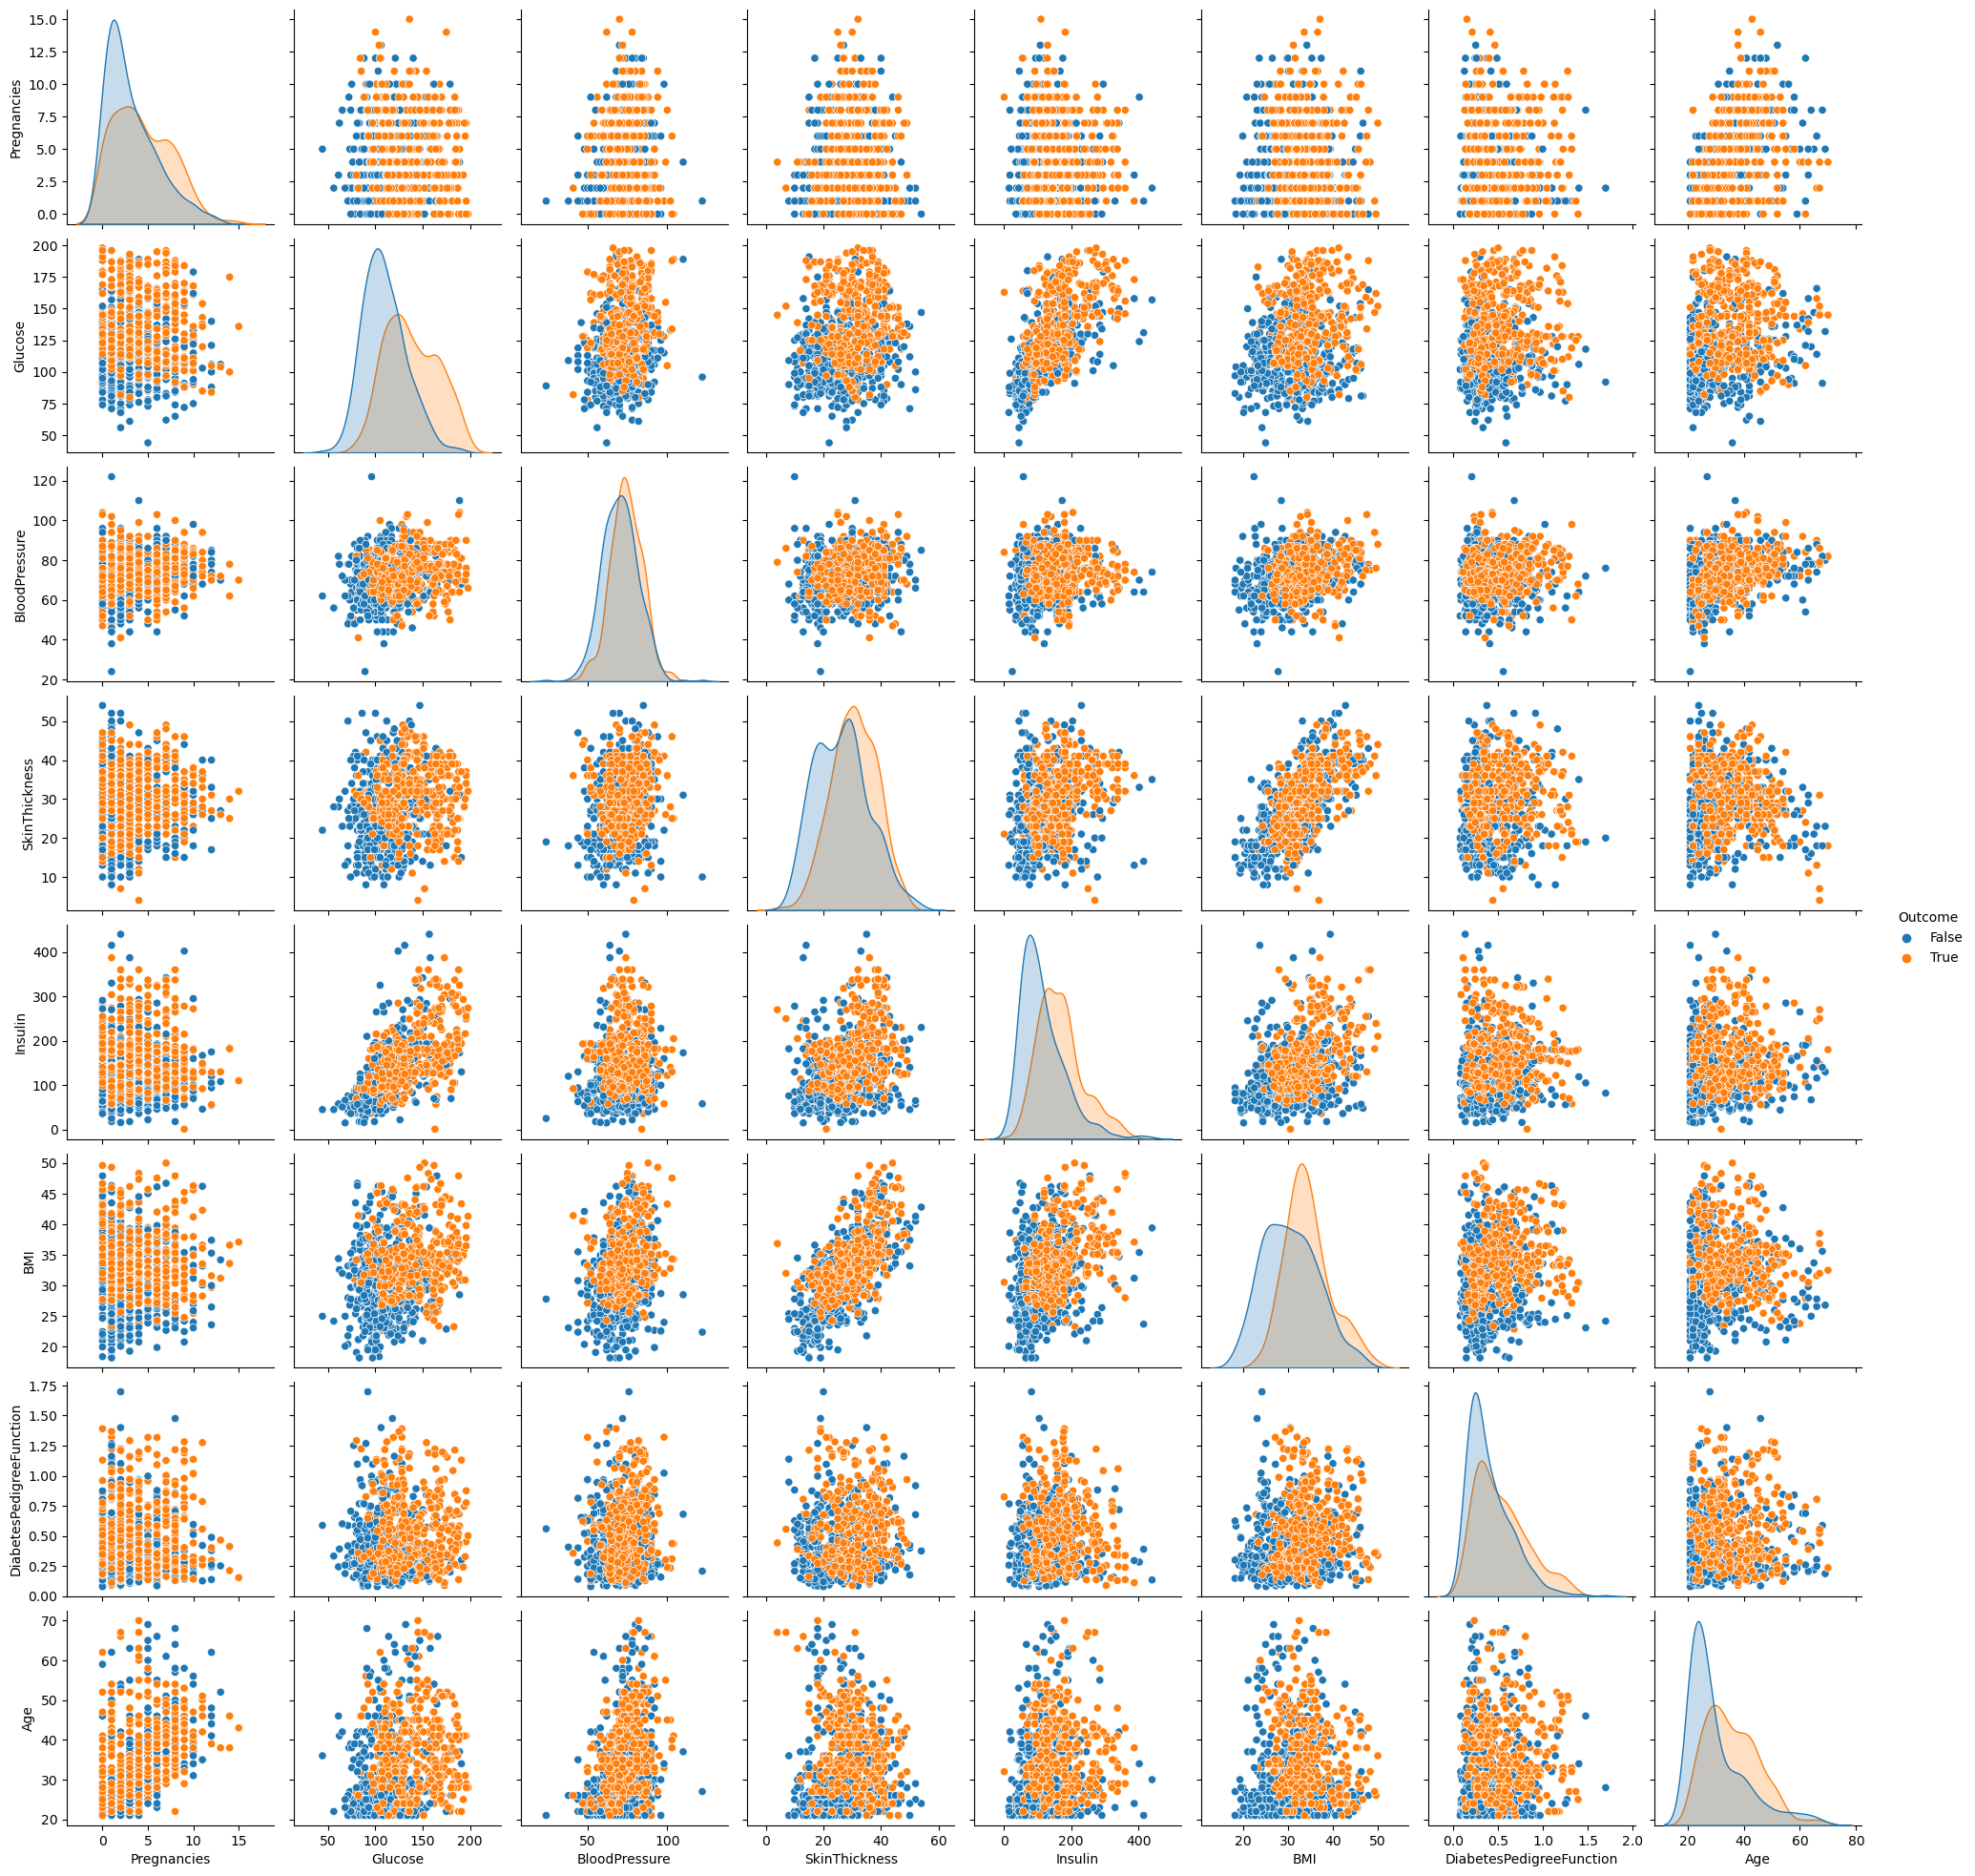

In [18]:
#again with the beloved pairplot
sns.pairplot(pd.concat([X_train, y_train], axis=1), hue='Outcome');

Appearently, the more or any feature the more chance of diabetes. We'll take a look at the correlation matrix.

In [19]:
pd.concat([X_train, y_train], axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               852 non-null    float64
 1   Glucose                   852 non-null    int64  
 2   BloodPressure             852 non-null    float64
 3   SkinThickness             852 non-null    float64
 4   Insulin                   852 non-null    float64
 5   BMI                       852 non-null    float64
 6   DiabetesPedigreeFunction  852 non-null    float64
 7   Age                       852 non-null    int64  
 8   Outcome                   852 non-null    bool   
dtypes: bool(1), float64(6), int64(2)
memory usage: 60.7 KB


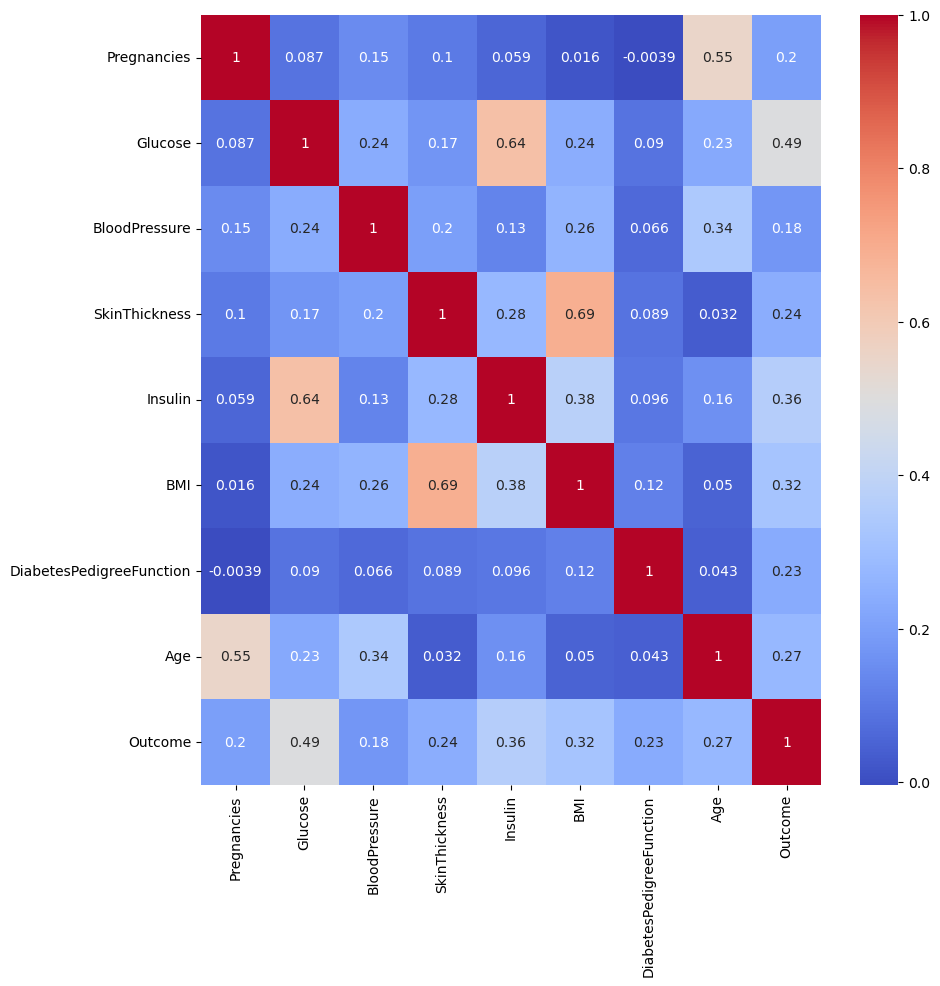

In [20]:
#correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(pd.concat([X_train, y_train], axis=1).corr(), annot=True, cmap='coolwarm');

* Pregnancies is moderately correlated with age, age itself is weakly correlated with Diabetes and pregnancies is weakly correlated because of that.
* Glucose is weakly correlated with Blood Pressure, strongly with Insulin and Diabetes.
* Insulin is weakly correlated with Skin Thickness, and note that skin thickness may be a symptom of insulin resistance. and obesity.
* BMI is highly correlated with Skin Thickness, and that makes sense.
* Diabetes Pedigree Function has a very weak correlation with all of them, and that makes sense as it shouldn't depend on any of them, given that it's a case sensitive score, and it's more correlated with the chance of diabetes as it should be.
* Age is weakly correlated with Blood Pressure and Diabetes and that makes sense.

Appearnetly, the most linearly correlated features are Glucose and Insulin, and BMI and Age. We'll take a look at the nonlinearity of the features.

In [21]:
ppMat = pps.matrix(pd.concat([X_train, y_train], axis=1))
ppMat

x                         y   ppscore            case  \
0   Pregnancies               Pregnancies  1.000000  predict_itself   
1   Pregnancies                   Glucose  0.000000      regression   
2   Pregnancies             BloodPressure  0.002987      regression   
3   Pregnancies             SkinThickness  0.010699      regression   
4   Pregnancies                   Insulin  0.000000      regression   
..          ...                       ...       ...             ...   
76      Outcome                   Insulin  0.070044      regression   
77      Outcome                       BMI  0.036991      regression   
78      Outcome  DiabetesPedigreeFunction  0.000000      regression   
79      Outcome                       Age  0.032176      regression   
80      Outcome                   Outcome  1.000000  predict_itself   

    is_valid_score               metric  baseline_score  model_score  \
0             True                 None        0.000000     1.000000   
1             True  mean absolute error       23.330986    23.443490   
2             True  mean absolute error        8.555164     8.529609   
3             True  mean absolute error        7.266432     7.188690   
4             True  mean absolute error       55.679577    57.018863   
..             ...                  ...             ...          ...   
76            True  mean absolute error       55.679577    51.779561   
77            True  mean absolute error        4.767476     4.591122   
78            True  mean absolute error        0.216887     0.217128   
79            True  mean absolute error        8.258216     7.992496   
80            True                 None        0.000000     1.000000   

                      model  
0                      None  
1   DecisionTreeRegressor()  
2   DecisionTreeRegressor()  
3   DecisionTreeRegressor()  
4   DecisionTreeRegressor()  
..                      ...  
76  DecisionTreeRegressor()  
77  DecisionTreeRegressor()  
78  DecisionTreeRegressor()  
79  DecisionTreeRegressor()  
80                     None  

[81 rows x 9 columns]

In [22]:
(ppMat.query('y == "Outcome" and ppscore > 0 and x != "Outcome" and baseline_score < model_score')[['x', 'ppscore']]
 .sort_values('ppscore', ascending=False))

x   ppscore
17                   Glucose  0.322792
71                       Age  0.316120
44                   Insulin  0.284570
35             SkinThickness  0.176664
53                       BMI  0.162572
8                Pregnancies  0.118244
26             BloodPressure  0.109830
62  DiabetesPedigreeFunction  0.029559

Just like how we saw in the correlation matrix, the most linearly correlated features are Glucose, Age, and Insulin in order. Pregnancies has a high score here because it's correlated with age, and age is correlated with diabetes. We'll take a look at the linear correlation between the features and the target variable. SkinThickness is the new guy in the hood, we may use that besides BMI.

__Note__ that we now can accept both of the alternative hypotheses we defined above.

Since most of the features are important, we're less likely to use PCA. We'll use LDA instead just to adjust the data to the best possible way.

In [23]:
X_train.duplicated().sum() == 0 #checking for duplicates before hitting the models

True

### Baselines

In [24]:
#logistic regression will be our baseline model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
print(classification_report(y_train, lr.predict(X_train)))

              precision    recall  f1-score   support

       False       0.74      0.73      0.73       444
        True       0.71      0.72      0.71       408

    accuracy                           0.72       852
   macro avg       0.72      0.72      0.72       852
weighted avg       0.72      0.72      0.72       852



Logistic regression is actually promising here, as it's a binary classification problem. We'll take a look at the ROC curve.

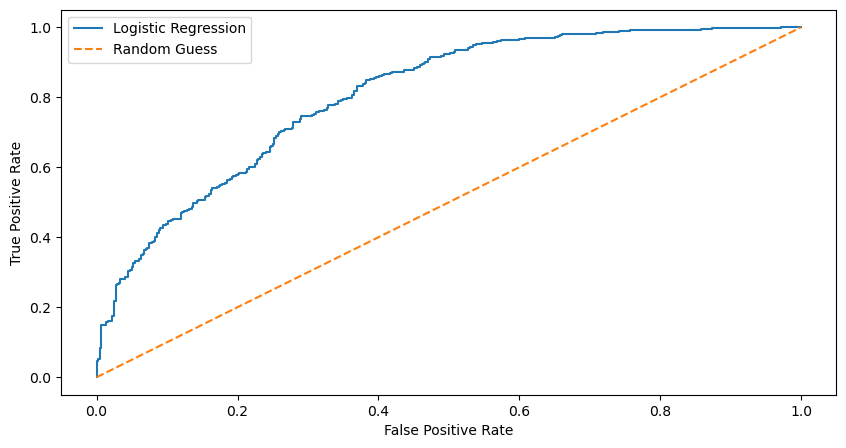

In [25]:
#roc curve using cross validation
y_pred = cross_val_predict(lr, X_train, y_train, cv=5, method='predict_proba')[:,1]
fpro, tpro, thresholds = roc_curve(y_train, y_pred)
plt.figure(figsize=(10,5))
plt.plot(fpro, tpro, label='Logistic Regression')
plt.plot([0,1], [0,1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

In [26]:
#perform LDA
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train, y_train)
ldav = lda.transform(X_train)

In [27]:
ldareg = LogisticRegression(random_state=42)
ldareg.fit(ldav, y_train)

print(classification_report(y_train, ldareg.predict(ldav)))
print('roc/auc score: ', roc_auc_score(y_train, ldareg.predict(ldav)))

              precision    recall  f1-score   support

       False       0.74      0.78      0.76       444
        True       0.74      0.70      0.72       408

    accuracy                           0.74       852
   macro avg       0.74      0.74      0.74       852
weighted avg       0.74      0.74      0.74       852

roc/auc score:  0.7376788553259142


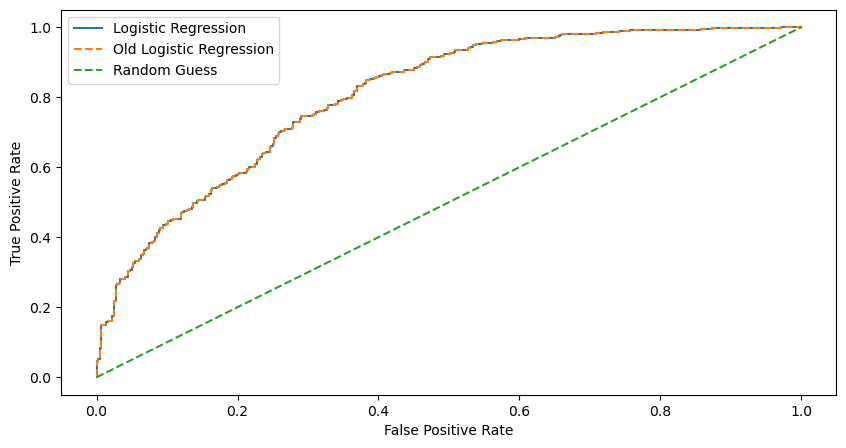

In [28]:
#roc curve using cross validation
y_pred = cross_val_predict(ldareg, X_train, y_train, cv=5, method='predict_proba')[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot(fpro, tpro, label='Old Logistic Regression', linestyle='--')
plt.plot([0,1], [0,1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

Number changed slightly to the better, the plot fluctuated more now, but the mean is still approximately the same.

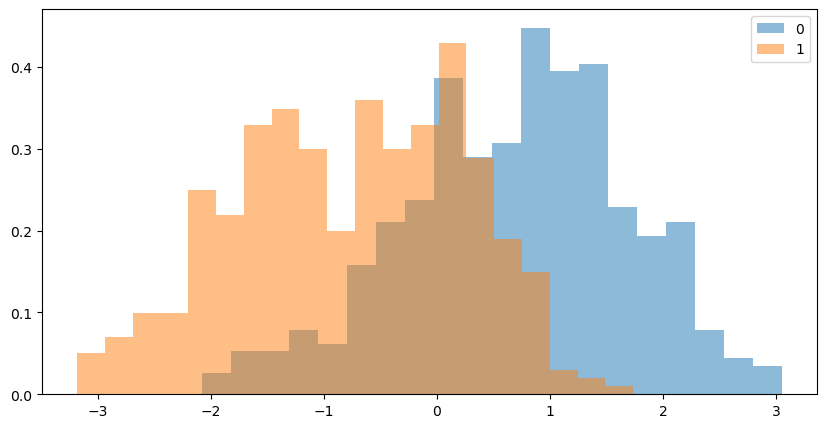

In [29]:
#hist ldav values hue outcome
plt.figure(figsize=(10,5))
plt.hist(ldav[y_train == 0], bins=20, alpha=0.5, label='0', density=True)
plt.hist(ldav[y_train == 1], bins=20, alpha=0.5, label='1', density=True)
plt.legend();

It's a significant difference, but not a perfect one.

In [30]:
#QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train);

In [31]:
print(classification_report(y_train, qda.predict(X_train)))

              precision    recall  f1-score   support

       False       0.76      0.80      0.78       444
        True       0.77      0.73      0.75       408

    accuracy                           0.77       852
   macro avg       0.77      0.76      0.76       852
weighted avg       0.77      0.77      0.76       852



Now we know we'll use the data we have and try the ldav as well.

In [32]:
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print(classification_report(y_train, dt.predict(X_train)))
print("roc/auc score: ", roc_auc_score(y_train, dt.predict_proba(X_train)[:,1]))

              precision    recall  f1-score   support

       False       0.87      0.66      0.75       444
        True       0.71      0.89      0.79       408

    accuracy                           0.77       852
   macro avg       0.79      0.78      0.77       852
weighted avg       0.79      0.77      0.77       852

roc/auc score:  0.8507165253488783


SURE

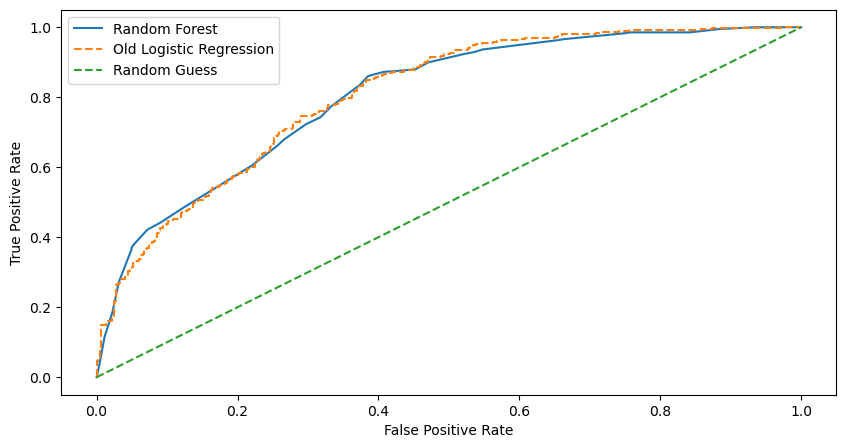

In [33]:
#roc curve using cross validation
y_pred = cross_val_predict(dt, X_train, y_train, cv=5, method='predict_proba')[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label='Random Forest')
plt.plot(fpro, tpro, label='Old Logistic Regression', linestyle='--')
plt.plot([0,1], [0,1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

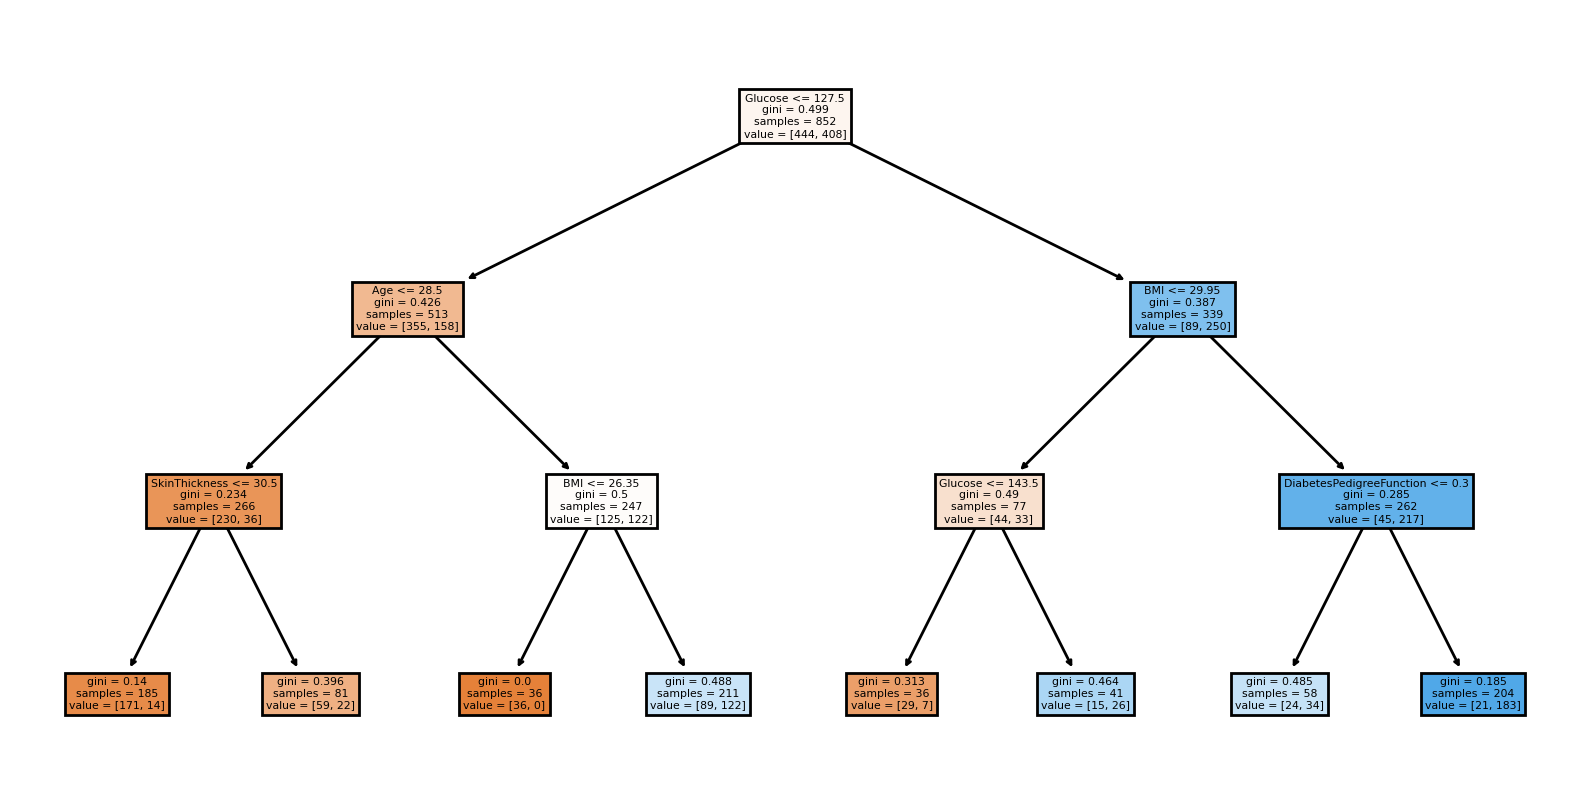

In [34]:
plt.figure(figsize=(10,5), dpi=200)
plot_tree(dt, filled=True, feature_names=X_train.columns);

The plot above shows the importance of the features, just like how PPS does. We may use the tree as a baseline as well.

## Let's hit the models.

1. Support Vector Machine
2. Nearest Neighbors
3. Ensemble methods
   1. Bagging
   2. Forests
   3. AdaBoost
   4. Gradient Tree Boosting
   5. Voting Classifier
   6. Stacked generalization

<center>
<figure>
    <img src="model (1).png" width="30%" height="30%" />
    <img src="model (2).png" width="30%" height="30%" />
    <img src="model (3).png" width="30%" height="30%" />
</figure>
</center>


### SVC

In [35]:
svc = SVC(random_state=42, probability=True)
(pd.DataFrame(cross_validate(svc, X_train, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.727699
train_accuracy    0.730637
test_roc_auc      0.813240
train_roc_auc     0.823333
dtype: float64

In [36]:
(pd.DataFrame(cross_validate(svc, ldav, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.750052
train_accuracy    0.745308
test_roc_auc      0.821906
train_roc_auc     0.823241
dtype: float64

$\Rightarrow$ Scores more using the ldav, but the scores are still not good.

### KNN

In [38]:
knc = KNeighborsClassifier(n_neighbors=5)
(pd.DataFrame(cross_validate(knc, X_train, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.738335
train_accuracy    0.813973
test_roc_auc      0.808423
train_roc_auc     0.910972
dtype: float64

In [39]:
(pd.DataFrame(cross_validate(knc, ldav, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.697234
train_accuracy    0.798127
test_roc_auc      0.785714
train_roc_auc     0.891733
dtype: float64

$\Rightarrow$ No improvement.

### Ensemble methods

#### Bagging

In [40]:
bag = BaggingClassifier(random_state=42)
(pd.DataFrame(cross_validate(bag, X_train, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.788813
train_accuracy    0.984741
test_roc_auc      0.865082
train_roc_auc     0.998894
dtype: float64

In [41]:
(pd.DataFrame(cross_validate(bag, ldav, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.694888
train_accuracy    0.962736
test_roc_auc      0.761622
train_roc_auc     0.995121
dtype: float64

$\Rightarrow$ No improvement.

#### Forests

In [42]:
rf = RandomForestClassifier(random_state=42)
(pd.DataFrame(cross_validate(rf, X_train, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.806433
train_accuracy    1.000000
test_roc_auc      0.889768
train_roc_auc     1.000000
dtype: float64

In [43]:
(pd.DataFrame(cross_validate(rf, ldav, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.692521
train_accuracy    0.999707
test_roc_auc      0.783148
train_roc_auc     1.000000
dtype: float64

$\Rightarrow$ This is definitely better. We'll stick with vc on full $X_{train}$.

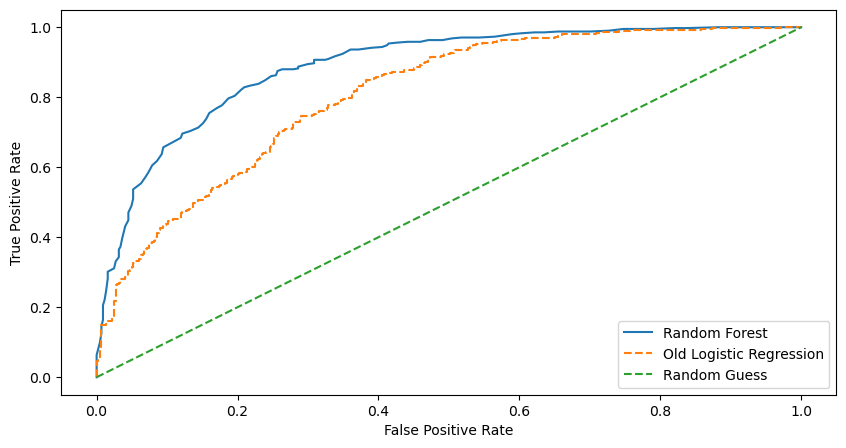

In [44]:
#roc curve using cross validation
y_pred = cross_val_predict(rf, X_train, y_train, cv=5, method='predict_proba')[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label='Random Forest')
plt.plot(fpro, tpro, label='Old Logistic Regression', linestyle='--')
plt.plot([0,1], [0,1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

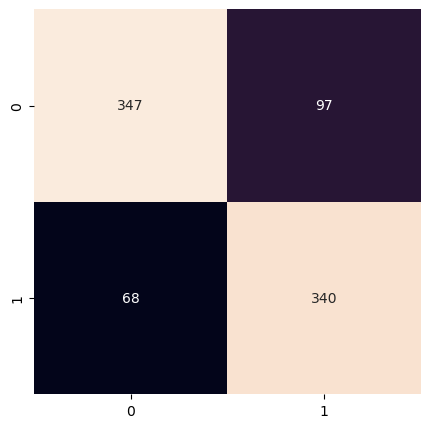

In [45]:
#cross validated confusion matrix
y_pred = cross_val_predict(rf, X_train, y_train, cv=5)

#plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cbar=False);

#### AdaBoost

In [46]:
ada = AdaBoostClassifier(random_state=42)
(pd.DataFrame(cross_validate(ada, X_train, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.766460
train_accuracy    0.834809
test_roc_auc      0.835127
train_roc_auc     0.926152
dtype: float64

In [47]:
(pd.DataFrame(cross_validate(ada, ldav, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.740681
train_accuracy    0.771721
test_roc_auc      0.825759
train_roc_auc     0.875556
dtype: float64

$\Rightarrow$ Nope.

#### Gradient Tree Boosting

In [48]:
gb = GradientBoostingClassifier(random_state=42)
(pd.DataFrame(cross_validate(gb, X_train, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.797007
train_accuracy    0.930170
test_roc_auc      0.869337
train_roc_auc     0.982580
dtype: float64

$\Rightarrow$ No improvement.

#### Voting Classifier

In [49]:
vc = VotingClassifier(estimators=[('lr', lr), ('lda', lda), ('qda', qda), ('dt', dt), ('svc', svc), ('knc', knc)], voting='soft')
(pd.DataFrame(cross_validate(vc, X_train, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.768848
train_accuracy    0.803118
test_roc_auc      0.859377
train_roc_auc     0.892265
dtype: float64

In [50]:
(pd.DataFrame(cross_validate(vc, ldav, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.732460
train_accuracy    0.761157
test_roc_auc      0.839560
train_roc_auc     0.865391
dtype: float64

$\Rightarrow$ Nah.

#### Stacked generalization

In [51]:
sc = StackingClassifier(estimators=[('bag', bag), ('rf', rf), ('ada', ada), ('gb', gb)], final_estimator=svc)
(pd.DataFrame(cross_validate(sc, X_train, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.797000
train_accuracy    0.994719
test_roc_auc      0.860036
train_roc_auc     0.999871
dtype: float64

In [52]:
(pd.DataFrame(cross_validate(sc, ldav, y_train, cv=5, scoring=('accuracy', 'roc_auc'), return_train_score=True))
[['test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc']].mean())

test_accuracy     0.718369
train_accuracy    0.835976
test_roc_auc      0.797569
train_roc_auc     0.897932
dtype: float64

$\Rightarrow$ Not this time then.

## We'll try to fine tune the Random Forest Classifier.

## Conclusion

Now we have our model, we know our best indicators of diabetes, and we know how to predict diabetes. We can use the model (Random Forest) to predict diabetes, and it will be close to the validation score.

## Future work

* Use the whole dataset, and not just the undersampled one.
* Fine tuning the base estimators of the voting classifier.
* Try other models.